In [6]:
import numpy as np
import pandas as pd
from astropy import units as u, constants as con
import matplotlib.pyplot as plt
from itertools import combinations

# %matplotlib ipympl

In [7]:
df = pd.read_csv('./meerkat.csv', delimiter='\t')
df

,Antenna,East,North,Up
0,m000,-8.264,-207.290,8.597
1,m001,1.121,-171.762,8.471
2,m002,-32.113,-224.236,8.645
3,m003,-66.518,-202.276,8.285
4,m004,-123.624,-252.946,8.513
...,...,...,...,...
59,m059,3686.427,758.895,11.822
60,m060,3419.683,-1840.478,23.697
61,m061,-16.409,-2323.779,21.304
62,m062,-1440.632,-2503.773,21.683


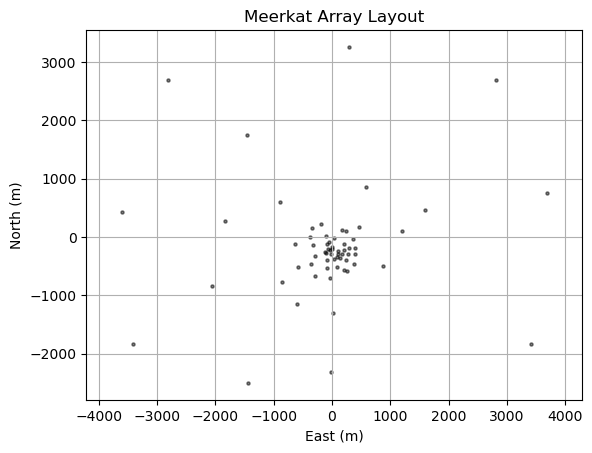

In [8]:
plt.figure()
plt.scatter(df['East'], df['North'], s=5, c='k', alpha=0.5)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.title('Meerkat Array Layout')
plt.grid()
plt.axis('equal')
plt.show()

Number of core antennas: 44 / 64


(-3970.5762, 4051.0462, -2791.9574000000002, 3548.0994)

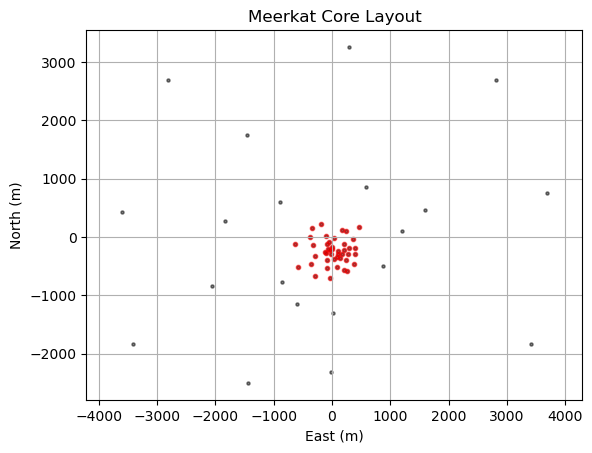

In [9]:
core_idxs = (df['East']**2 + df['North']**2) < 1000**2
print(f'Number of core antennas: {core_idxs.sum()} / {len(df)}')
core = df[core_idxs]
plt.figure()
plt.scatter(df['East'], df['North'], s=5, c='k', alpha=0.5)
plt.scatter(core['East'], core['North'], s=10, c='r', alpha=0.5)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.title('Meerkat Core Layout')
plt.grid()
plt.axis('equal')

In [10]:
n_antennas = len(df)
pairs = np.array(list(combinations(range(n_antennas), 2)))
n_baselines = len(pairs)
print(n_baselines, n_antennas * (n_antennas - 1) // 2)

2016 2016


In [11]:
baselines = np.empty((n_baselines, 3))
for i, (ant1, ant2) in enumerate(pairs):
    baselines[i] = df.iloc[ant1][['East', 'North', 'Up']].values - df.iloc[ant2][['East', 'North', 'Up']].values

baselines = baselines * u.m

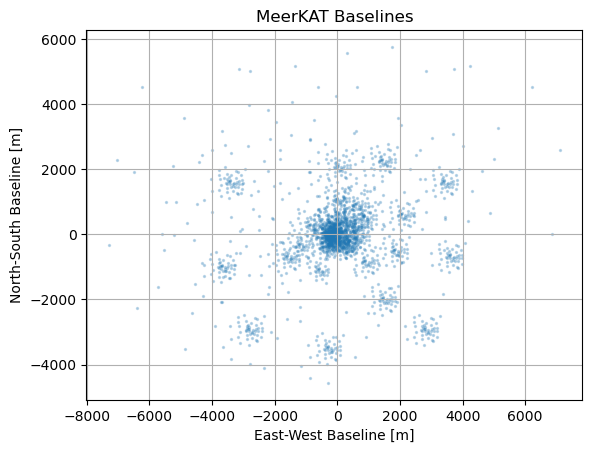

In [12]:
plt.figure()
plt.scatter(baselines[:, 0].to(u.m).value, baselines[:, 1].to(u.m).value, s=2, alpha=0.25)
plt.grid()
plt.xlabel('East-West Baseline [m]')
plt.ylabel('North-South Baseline [m]')
plt.title('MeerKAT Baselines')
plt.show()
plt.close()

946 880 190 2016


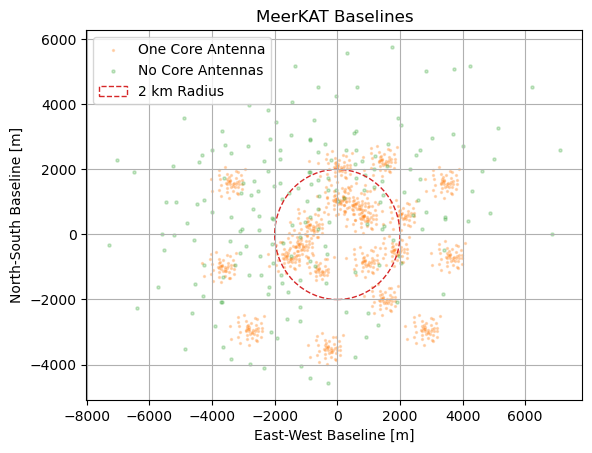

In [17]:
antonein = np.isin(pairs[:, 0], np.arange(len(df))[core_idxs])
anttwoin = np.isin(pairs[:, 1], np.arange(len(df))[core_idxs])
bothcorebls = baselines[antonein & anttwoin]
onecorebls = baselines[antonein ^ anttwoin]
nocorebls = baselines[~(antonein | anttwoin)]
print(len(bothcorebls), len(onecorebls), len(nocorebls), len(bothcorebls) + len(onecorebls) + len(nocorebls))



plt.figure()
# plt.scatter(bothcorebls[:, 0].to(u.m).value, bothcorebls[:, 1].to(u.m).value, s=2, alpha=0.25, label='Both Core Antennas', color='C0')
plt.scatter(onecorebls[:, 0].to(u.m).value, onecorebls[:, 1].to(u.m).value, s=2, alpha=0.25, label='One Core Antenna', color='C1')
plt.scatter(nocorebls[:, 0].to(u.m).value, nocorebls[:, 1].to(u.m).value, s=5, alpha=0.25, label='No Core Antennas', color='C2')
plt.grid()
plt.xlabel('East-West Baseline [m]')
plt.ylabel('North-South Baseline [m]')
plt.title('MeerKAT Baselines')
# draw a circle of 1 km radius
circle = plt.Circle((0, 0), 2000, color='C3', fill=False, linestyle='--', label='2 km Radius')
plt.gca().add_artist(circle)
plt.legend()
plt.show()

In [18]:
bothcoremags = (bothcorebls[:, 0]**2 + bothcorebls[:, 1]**2 + bothcorebls[:, 2]**2) ** 0.5
onecoremags = (onecorebls[:, 0]**2 + onecorebls[:, 1]**2 + onecorebls[:, 2]**2) ** 0.5
nocoremags = (nocorebls[:, 0]**2 + nocorebls[:, 1]**2 + nocorebls[:, 2]**2) ** 0.5
print(np.min(bothcoremags).to(u.m), np.max(bothcoremags).to(u.km), len(bothcoremags))
print(np.min(onecoremags).to(u.m), np.max(onecoremags).to(u.km), len(onecoremags))
print(np.min(nocoremags).to(u.m), np.max(nocoremags).to(u.km), len(nocoremags))

29.25652099959939 m 1.2492728031735103 km 946
370.8058110736669 m 4.660332026596925 km 880
458.2064882932148 m 7.697580391232104 km 190


In [19]:
44 * 43 // 2, 44 * 20, 20 * 19 // 2

(946, 880, 190)

In [30]:
# keep all bothcore and half of onecore
n_baselines_corr = len(bothcorebls) + len(onecorebls) / 2 + len(onecorebls) / 4 + len(nocorebls) / 4
print(n_baselines_corr)

density = n_baselines_corr / (np.pi * (2000**2))
print(density)

noncorr_n_baselines = len(nocorebls) + len(onecorebls) + len(bothcorebls)
print(noncorr_n_baselines)
density_noncorr = noncorr_n_baselines / (np.pi * (7700**2))
print(density_noncorr)

1653.5
0.00013158134920122447
2016
1.0823287747453567e-05


[0.39652033 2.46903728 0.64724142]


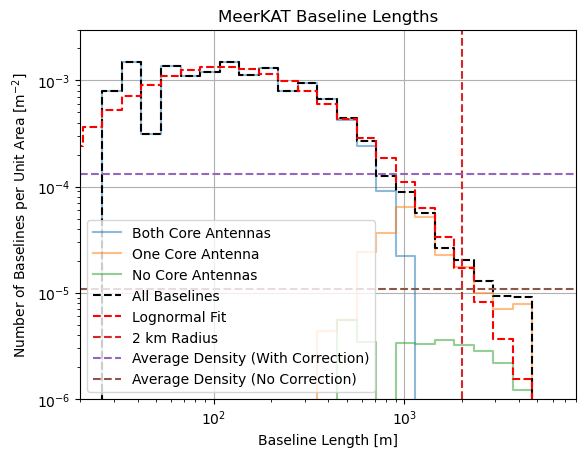

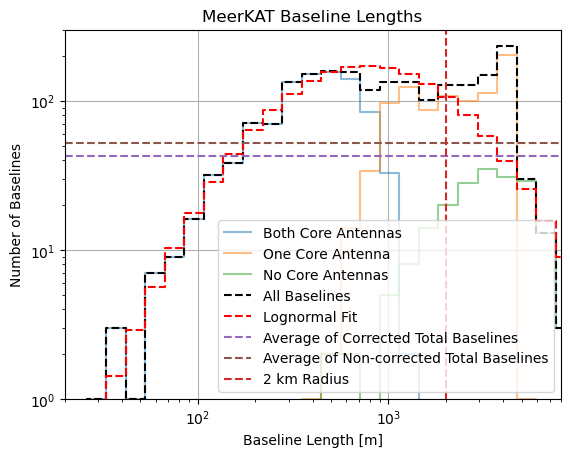

In [37]:
bins = np.logspace(1, 5, 40)
# bins = np.linspace(0, 8000, 50)
bincenters = 0.5 * (bins[1:] + bins[:-1])
histbothcores, _ = np.histogram(bothcoremags.to(u.m).value, bins=bins)
histonecore, _ = np.histogram(onecoremags.to(u.m).value, bins=bins)
histnocore, _ = np.histogram(nocoremags.to(u.m).value, bins=bins)

lognormal = lambda x, A, mu, sigma: A/(x * sigma * (2 * np.pi)**0.5) * 10 ** (-(np.log10(x) - mu)**2 / (2 * sigma**2))
gaussian = lambda x, A, mu, sigma: A/(sigma * (2 * np.pi)**0.5) * np.exp(-(x - mu)**2 / (2 * sigma**2))
bestfitmodel = lognormal
p0 = [2, 1, 1]

areas = np.pi * (bins[1:]**2 - bins[:-1]**2)
total_area = np.pi * (bins[-1]**2)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(bestfitmodel, bincenters, (histbothcores + histonecore + histnocore) / areas, p0=p0)
print(popt)
bestfit_dens = bestfitmodel(bincenters, *popt)

plt.figure()
plt.step(bincenters, histbothcores / areas, where='mid', label='Both Core Antennas', color='C0', alpha=0.5)
plt.step(bincenters, histonecore / areas, where='mid', label='One Core Antenna', color='C1', alpha=0.5)
plt.step(bincenters, histnocore / areas, where='mid', label='No Core Antennas', color='C2', alpha=0.5)
plt.step(bincenters, (histbothcores + histonecore + histnocore) / areas, where='mid', label='All Baselines', color='k', linestyle='--')
plt.step(bincenters, bestfit_dens, where='mid', label='Lognormal Fit', color='r', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Number of Baselines per Unit Area [m$^{-2}$]')
plt.xlabel('Baseline Length [m]')
plt.title('MeerKAT Baseline Lengths')
plt.axvline(2000, color='C3', linestyle='--', label='2 km Radius')
plt.axhline(density, color='C4', linestyle='--', label='Average Density (With Correction)')
plt.axhline(density_noncorr, color='C5', linestyle='--', label='Average Density (No Correction)')
plt.ylim(1e-6, 3e-3)
plt.xlim(20, 8e3)
plt.legend()
plt.grid()
plt.show()

bestfit_num = bestfit_dens * areas

plt.figure()
plt.step(bincenters, histbothcores, where='mid', label='Both Core Antennas', color='C0', alpha=0.5)
plt.step(bincenters, histonecore, where='mid', label='One Core Antenna', color='C1', alpha=0.5)
plt.step(bincenters, histnocore, where='mid', label='No Core Antennas', color='C2', alpha=0.5)
plt.step(bincenters, histbothcores + histonecore + histnocore, where='mid', label='All Baselines', color='k', linestyle='--')
plt.step(bincenters, bestfit_num, where='mid', label='Lognormal Fit', color='r', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Baseline Length [m]')
plt.ylabel('Number of Baselines')
plt.title('MeerKAT Baseline Lengths')
plt.axhline(n_baselines_corr / len(bincenters), color='C4', linestyle='--', label='Average of Corrected Total Baselines')
plt.axhline(noncorr_n_baselines / len(bincenters), color='C5', linestyle='--', label='Average of Non-corrected Total Baselines')
plt.axvline(2000, color='C3', linestyle='--', label='2 km Radius')
plt.ylim(1e0, 3e2)
plt.xlim(20, 8e3)
plt.legend()
plt.grid()
plt.show()



/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31132/4074527640.py:11: RuntimeWarning: divide by zero encountered in log10
  cp = plt.contourf(Xc, Yc, np.log10(H.T), levels=20, cmap='viridis')


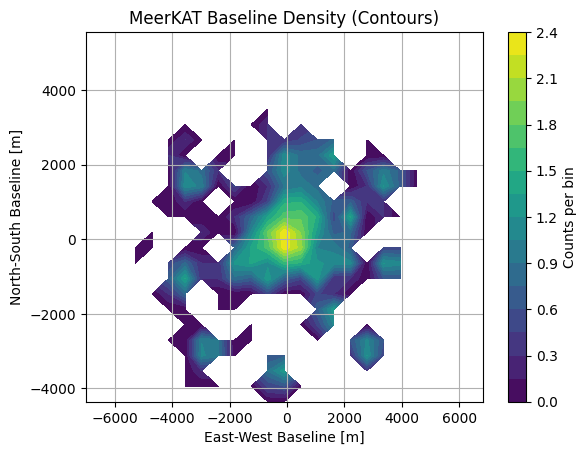

In [6]:
# 2D histogram and contour plot of baseline density
x = baselines[:, 0].to(u.m).value
y = baselines[:, 1].to(u.m).value

# Create 2D histogram
nbins = 25
H, xedges, yedges = np.histogram2d(x, y, bins=nbins)
Xc, Yc = np.meshgrid(0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1]))

plt.figure()
cp = plt.contourf(Xc, Yc, np.log10(H.T), levels=20, cmap='viridis')
plt.colorbar(cp, label='Counts per bin')
plt.xlabel('East-West Baseline [m]')
plt.ylabel('North-South Baseline [m]')
plt.title('MeerKAT Baseline Density (Contours)')
plt.grid()
plt.show()
plt.close()

In [7]:
# bin by magnitude
basemags = np.sqrt(baselines[:, 0]**2 + baselines[:, 1]**2 + baselines[:, 2]**2).to(u.m).value

nbins = 25
logbl_bins = np.logspace(np.log10(basemags.min()), np.log10(basemags.max()), nbins)
linbl_bins = np.linspace(basemags.min(), basemags.max(), nbins)
logbl_cens = 0.5 * (logbl_bins[1:] + logbl_bins[:-1])
linbl_cens = 0.5 * (linbl_bins[1:] + linbl_bins[:-1])

logbinned_bl = np.histogram(basemags, bins=logbl_bins)[0]
linbinned_bl = np.histogram(basemags, bins=linbl_bins)[0]

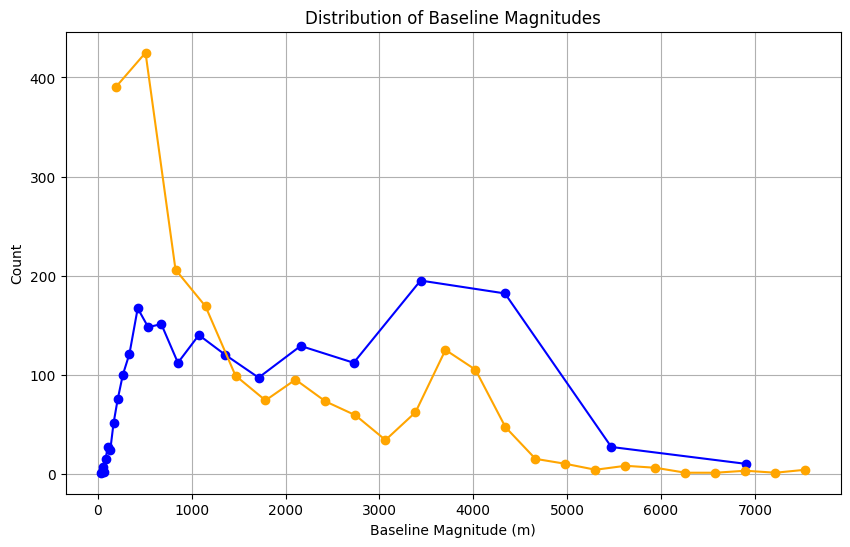

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(logbl_cens, logbinned_bl, marker='o', label='Log Binned', color='blue')
plt.plot(linbl_cens, linbinned_bl, marker='o', label='Linear Binned', color='orange')
# plt.xscale('log')
plt.xlabel('Baseline Magnitude (m)')
plt.ylabel('Count')
plt.title('Distribution of Baseline Magnitudes')
plt.grid()
plt.show()

In [9]:
from astropy.cosmology import Planck18 as cosmo

Z_FOR_MODELLING = 1.0
lamb21hi = 21 * u.cm
kperps = basemags * u.m * 2 * np.pi / lamb21hi / cosmo.comoving_transverse_distance(Z_FOR_MODELLING)
kperps = kperps.to(1/u.Mpc).value

In [ ]:
# bin by magnitude
nbins = 25
logkperps_bins = np.logspace(np.log10(kperps.min()), np.log10(kperps.max()), nbins)
linkperps_bins = np.linspace(kperps.min(), kperps.max(), nbins)
logkperps_cens = 0.5 * (logkperps_bins[1:] + logkperps_bins[:-1])
linkperps_cens = 0.5 * (linkperps_bins[1:] + linkperps_bins[:-1])

logbinned_kperps = np.histogram(kperps, bins=logkperps_bins)[0]
linbinned_kperps = np.histogram(kperps, bins=linkperps_bins)[0]

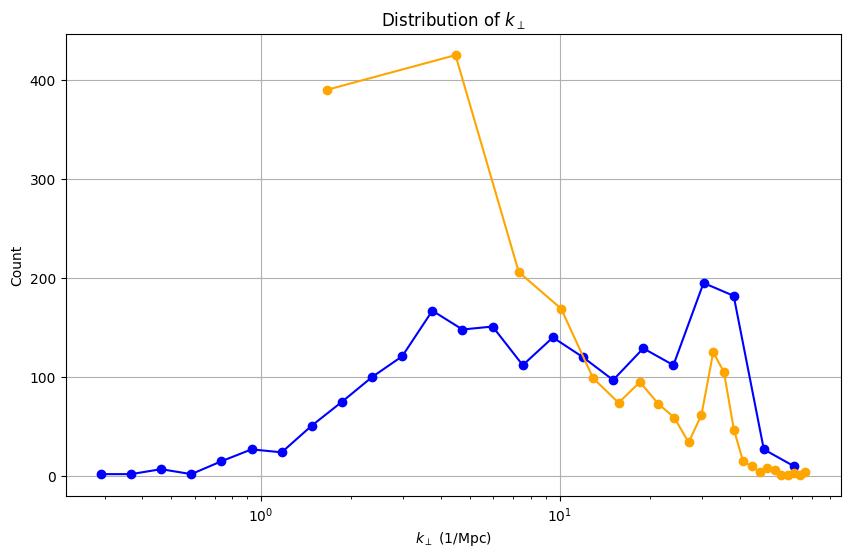

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(logkperps_cens, logbinned_kperps, marker='o', label='Log Binned', color='blue')
plt.plot(linkperps_cens, linbinned_kperps, marker='o', label='Linear Binned', color='orange')
plt.xscale('log')
plt.xlabel(r'$k_\perp$ (1/Mpc)')
plt.ylabel('Count')
plt.title('Distribution of $k_\perp$')
plt.grid()
plt.show()

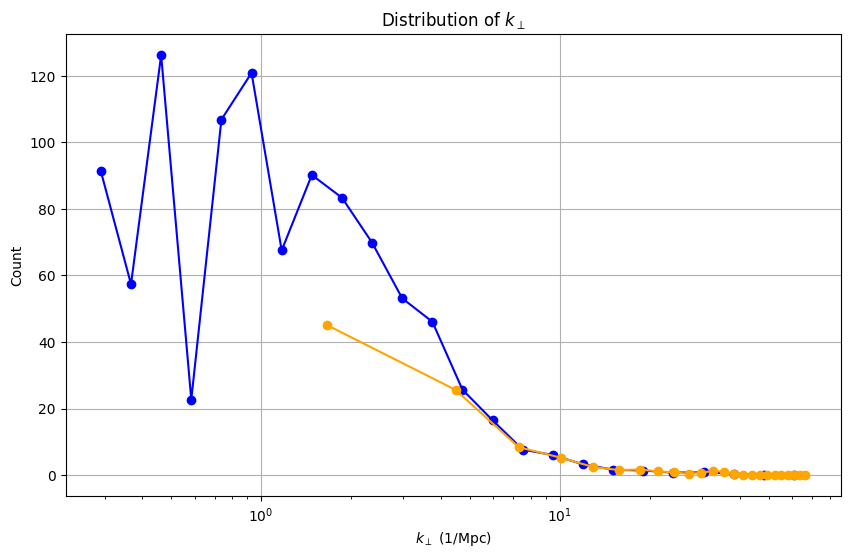

In [27]:
# number density
plt.figure(figsize=(10, 6))
plt.plot(logkperps_cens, logbinned_kperps / (logkperps_bins[1:] * (logkperps_bins[1:] - logkperps_bins[:-1])), marker='o', label='Log Binned', color='blue')
plt.plot(linkperps_cens, linbinned_kperps / (linkperps_bins[1:] * (linkperps_bins[1:] - linkperps_bins[:-1])), marker='o', label='Linear Binned', color='orange')
plt.xscale('log')
plt.xlabel(r'$k_\perp$ (1/Mpc)')
plt.ylabel('Count')
plt.title('Distribution of $k_\perp$')
plt.grid()
plt.show()